In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('TakeHome_task_data.csv')
pd.set_option('display.max_colwidth', -1)
df.head(5)

,data,label,new_label
0,"{'id': 'KG0OUA', 'data': 'Good morning', 'message_order': 2, 'comments': ['']}",location,3
1,"{'id': 'L9DC9H', 'data': 'Location', 'message_order': 5, 'comments': ['']}",whoAreYou,1
2,"{'id': 'ZQR6R5', 'data': 'hi', 'message_order': 5, 'comments': ['']}",whoAreYou,3
3,"{'id': 'RH0M4E', 'data': 'Hi', 'message_order': 4, 'comments': ['']}",greeting,3
4,"{'id': 'WLVX8I', 'data': 'Hello', 'message_order': 1, 'comments': ['']}",greeting,3


In [3]:
#obtaining the important parts of the data from the csv file i.e 'message', 'message_order', 'intent label'

ndf = df['data'].str.split(',')

ndata = list()
for i in range(ndf.size):
    ndata.append(ndf[i][1])
    
final_data = list()
for i in range(len(ndata)):
    final_data.append(ndata[i].split(':')[1])
    
m_order = list()
for i in range(ndf.size):
    if i in (75, 247, 458, 464, 631, 1269, 1459, 1601, 1651, 1803, 1918): #a bit crude but works for now
        m_order.append(ndf[i][3])
    else:
        m_order.append(ndf[i][2])
    
final_m_order = list()
for i in range(len(m_order)):
    final_m_order.append(m_order[i].split(':')[1])

    
data = pd.DataFrame(final_data, columns = ['text']).assign(message_order = final_m_order)
data = data.assign(label = df.label)
data.text = data.text.apply(str)
data.message_order = pd.to_numeric(data.message_order)
data = data.assign(label = df.new_label)

data.head(5)

,text,message_order,label
0,'Good morning',2,3
1,'Location',5,1
2,'hi',5,3
3,'Hi',4,3
4,'Hello',1,3


In [4]:
intent = data.label
unique_intents = list(set(data.label))
unique_intents

[1, 2, 3, 4, 5, 6]

In [5]:
my_map = {'location': 1,'saidOK': 2, 'greeting' : 3, 'dontMeetRequirements' : 4, 'notInterested' : 5, 'hasLL' : 6}
inv_map = {v: k for k, v in my_map.items()}

In [6]:
#Converting numeric labels to their corresponding text based label

text_labels = list([inv_map[key] for key in data.label])
data['text_label'] = text_labels

In [7]:
data.head(5)

,text,message_order,label,text_label
0,'Good morning',2,3,greeting
1,'Location',5,1,location
2,'hi',5,3,greeting
3,'Hi',4,3,greeting
4,'Hello',1,3,greeting


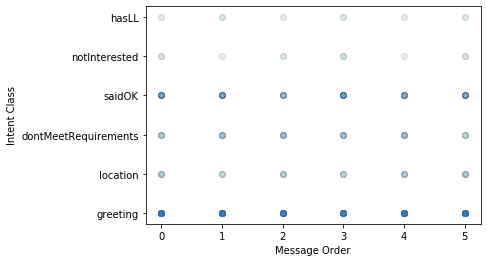

In [8]:
#Visualizing distribution of intent classification over message_orders (the dataset has fewer examples with class = 4,5)

x = np.array(data.message_order)
y = np.array(data.text_label)

plt.xlabel('Message Order')
plt.ylabel('Intent Class')

plt.scatter(x,y, alpha = 0.007)
plt.show()

In [9]:
message = np.array(data.text)
message_order = np.array(data.message_order)
labels = np.array(data.label)

for i in range(6):
    print('Examples of class ' + str(i+1) + ' =', np.sum(labels == i+1))

Examples of class 1 = 233
Examples of class 2 = 447
Examples of class 3 = 832
Examples of class 4 = 279
Examples of class 5 = 111
Examples of class 6 = 98


In [10]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Approach - 

#1. For such short sentences, it would not be feasible to generate my own word vectors using word2vec

#2. Can't use pre-trained word vectors as data has non-english words, and many misspelt words

#3. So, we can use sentence vectors created from word indices in the vocabulary. Besides the aforementioned reasons,
#here is the intuition for it- Since the users' response are directed towards a particular intent and have very less words,
#we can expect that there are a few 'key-words' that contain most of the semantics, as there only so many ways common ways,
#to convey the idea in 2-5 words (which is the average size of a sentence in the dataset)

#4. We can even try to improve the efficiency of this method by 'baiting/influencing' the user towards a particular choice
#of words in the way we form our counter-questions.

#Onwards with the implementation-------------------------------------

In [11]:
#shifting all data to lowercase and breaking sentences into word tokens

def cleaning(message):
    words = []
    for s in message:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        words.append([i.lower() for i in w])
    
    return words

In [12]:
cleaned_words = cleaning(message)
print(cleaned_words[:10])

[['good', 'morning'], ['location'], ['hi'], ['hi'], ['hello'], ['sir'], ['k'], ['on', 'thanks'], ['hii'], ['sir', 'i', 'dnt', 'have', 'two', 'wheeler']]


In [57]:
#Converts all 'kk' and 'okkk' to ok, but does not improve performance so left it out


new_cleaned_words = []
for words in cleaned_words:
    new_token = []
    for s in words:
        s = re.sub(r'^k$', 'ok', s, count=1 )
        s = re.sub(r'^kk+.*', 'ok', s, count=1)
        s = re.sub(r'o+h*k.*', 'ok', s, count=1)
        s = re.sub(r'([a-z]*)\1([i,y])\2+$', r'\2', s )
        new_token.append(s)
        
    new_cleaned_words.append(new_token)

print(new_cleaned_words[:10])
cleaned_words = new_cleaned_words



[['good', 'morning'], ['location'], ['hi'], ['hi'], ['hello'], ['sir'], ['ok'], ['on', 'thanks'], ['hi'], ['sir', 'i', 'dnt', 'have', 'two', 'wheeler']]


In [14]:
#Creating feature word_count and checking its relation to the data using histogram

word_count = []
for i in range(len(cleaned_words)):
    word_count.append(len(cleaned_words[i]))

word_count = np.array(word_count)
word_count[0:10]

array([2, 1, 1, 1, 1, 1, 1, 2, 1, 6])

(array([ 38.,   0., 412.,   0., 634.,   0.,  67.,   0.,  10.,  23.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

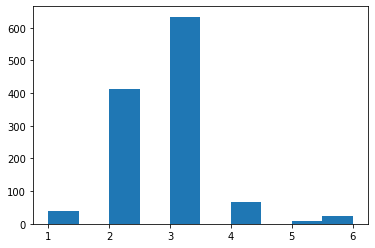

In [15]:
mask = (word_count <= 1)
x = labels[mask] 
plt.hist(x)

In [16]:
#creating feature word_count <=1

one_word = ((mask <= 1)*1).reshape(mask.size,1)

In [17]:
#Non- English messages have 0 word count because of how the cleaning_sentences function was defined

message[np.where(word_count == 0)]

array([" 'बाइक नहीं है'", " 'मेरे पास बाइक नही है'", " 'లేదు'",
       " 'जय महाराष्ट्र'", " 'లేదు'", " 'శుభోదయం'",
       " '👾 ಬೆಳಗಿನ ಶುಭೋದಯ ಗಳು'", " 'कुटे है'", " '", " 'नमस्कार'",
       " '😉✌'"], dtype=object)

In [18]:
#standard keras tokenizer procedure

def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [19]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = len(max(cleaned_words, key = len))

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 719 and Maximum length = 19


In [20]:
#obtaining the word vectors

vectors = word_tokenizer.texts_to_sequences(cleaned_words)
vectors[0:4]

#using matrix decomposition of co-occurence matrix won't work well here clearly due to the nature of the 'corpus'.

[[15, 20], [10], [2], [2]]

In [21]:
#adding zero padding to make size of all vectors equal

def padding_doc(vectors, max_length):
  return(pad_sequences(vectors, maxlen = max_length, padding = "post"))

padded_doc = padding_doc(vectors, max_length)

In [22]:
#Adding message order as an input feature

#message_order = message_order.reshape(2000,1)
#padded_doc = np.append(padded_doc, message_order, axis=1)
#padded_doc.shape

In [23]:
#adding word count nad one_word as a feature

word_count = np.array(word_count).reshape(2000,1)
padded_doc = np.append(padded_doc, word_count, axis=1)
padded_doc = np.append(padded_doc, one_word, axis=1)
max_length = padded_doc.shape[1]

padded_doc.shape, max_length

((2000, 21), 21)

In [24]:
#using one_hot representation for intent labels

labels = labels.reshape(2000,1)
labels.shape

(2000, 1)

In [25]:
#Preparing the test & training set, using Stratified sampling as classes are imbalanced

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss.get_n_splits(padded_doc, labels)

for train_index, test_index in sss.split(padded_doc, labels):
    train_X, val_X = padded_doc[train_index], padded_doc[test_index]
    train_Y, val_Y = labels[train_index], labels[test_index]
    
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
train_Y = encoder.fit_transform(train_Y)
val_Y = encoder.fit_transform(val_Y)

print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1600, 21) and train_Y = (1600, 6)
Shape of val_X = (400, 21) and val_Y = (400, 6)


C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "

In [26]:
#At this point we have our word vectors, output labels, training and validation datasets, and we can append the
#message_order value as a feature to the word vectors and feed the data to a model

In [27]:
#But our data is multilingual, to deal with that, we can first separate the data based on language and then train our model

In [28]:
#Using LSTM

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(6, activation = "softmax"))
  
  return model

In [29]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

W0729 22:28:01.139873 17604 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 22:28:01.157830 17604 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 22:28:01.160821 17604 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 22:28:01.672105 17604 deprecation_wrapper.py:119] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 128)           92032     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 363,622
Trainable params: 271,590
Non-trainable params: 92,032
_________________________________________________________________


In [30]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

hist = model.fit(train_X, train_Y, epochs = 35, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

W0729 22:28:01.994218 17604 deprecation.py:323] From C:\Users\asus\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1600 samples, validate on 400 samples
Epoch 1/35
1600/1600 [==============================] - 4s 2ms/step - loss: 1.5780 - acc: 0.3925 - val_loss: 1.4411 - val_acc: 0.4150

Epoch 00001: val_loss improved from inf to 1.44107, saving model to model.h5
Epoch 2/35
1600/1600 [==============================] - 2s 1ms/step - loss: 1.4273 - acc: 0.4431 - val_loss: 1.2722 - val_acc: 0.4850

Epoch 00002: val_loss improved from 1.44107 to 1.27224, saving model to model.h5
Epoch 3/35
1600/1600 [==============================] - 2s 1ms/step - loss: 1.2405 - acc: 0.5481 - val_loss: 1.0791 - val_acc: 0.7150

Epoch 00003: val_loss improved from 1.27224 to 1.07915, saving model to model.h5
Epoch 4/35
1600/1600 [==============================] - 2s 1ms/step - loss: 1.0270 - acc: 0.6719 - val_loss: 0.8700 - val_acc: 0.7175

Epoch 00004: val_loss improved from 1.07915 to 0.87004, saving model to model.h5
Epoch 5/35
1600/1600 [==============================] - 2s 1ms/step - loss: 0.9285 - acc: 0.7

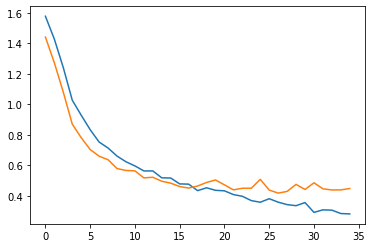

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [32]:
#We got a validation accuracy 0f ~87%

In [94]:
#Making some predictions

X = ["I have ll", 'hi! where is ur office', 'what is address', 'Hiii', 'oh ohk', 'stop messaging me', 
     'i dont have bike', 'good morning where is job', 'good morning tell address', 
     'good morning where is job', 'where is good morning', 'kkk thanks']

pred = cleaning(X)

new_cleaned_words = []
for words in pred:
    new_token = []
    for s in words:
        s = re.sub(r'^k$', 'ok', s, count=1 )
        s = re.sub(r'^k+.*', 'ok', s, count=1)
        s = re.sub(r'o+h*k.*', 'ok', s, count=1)
        s = re.sub(r'([a-z]*)\1([i,y])\2+$', r'\1\2', s )
        new_token.append(s)
        
    new_cleaned_words.append(new_token)

print(new_cleaned_words)
pred = new_cleaned_words



vector = word_tokenizer.texts_to_sequences(pred)
padded = padding_doc(vector, max_length =19)

count = []
for i in range(len(pred)):
    count.append(len(pred[i]))

count = np.array(count).reshape(len(count),1)
mask = (count <= 1)
one_word = ((mask <= 1)*1).reshape(mask.size, 1)
    
count = np.array(count).reshape(len(count),1)
padded = np.append(padded, count , axis=1)
padded = np.append(padded, one_word, axis=1)

intent = [inv_map[model.predict_classes(padded)[i] + 1] for i in range(len(X))]
intent

[['i', 'have', 'll'], ['hi', 'where', 'is', 'ur', 'office'], ['what', 'is', 'address'], ['hii'], ['oh', 'ok'], ['stop', 'messaging', 'me'], ['i', 'dont', 'have', 'bike'], ['good', 'morning', 'where', 'is', 'job'], ['good', 'morning', 'tell', 'address'], ['good', 'morning', 'where', 'is', 'job'], ['where', 'is', 'good', 'morning'], ['ok', 'thanks']]


['hasLL',
 'location',
 'location',
 'greeting',
 'greeting',
 'notInterested',
 'dontMeetRequirements',
 'location',
 'greeting',
 'location',
 'location',
 'saidOK']

In [34]:
#Converting val_Y back from one-hot to categorical and checking which examples our model got wrong

Y = np.argmax(val_Y, axis=1, out=None)
predictions = model.predict_classes(val_X)
wrongs = np.array(np.where(predictions != Y))

# % wrong in each class
print('% wrong classified in each category:\n')
for i in range(6):
    print('Category {} - '.format(i+1), (np.sum(Y[wrongs] == i) / np.sum([Y == i]))*100, '%')

% wrong classified in each category:

Category 1 -  14.893617021276595 %
Category 2 -  2.247191011235955 %
Category 3 -  3.614457831325301 %
Category 4 -  28.57142857142857 %
Category 5 -  50.0 %
Category 6 -  20.0 %


In [35]:
for train_index, test_index in sss.split(padded_doc, labels):
    mask = test_index
    
pred_wrong_msg = message[mask[wrongs]].reshape(wrongs.size,1)

pred_wrong_label = predictions[wrongs].reshape(wrongs.size,) + 1
wrong_pred = list(pred_wrong_label)

pred_wrong_text_labels = list([inv_map[key] for key in wrong_pred])

mistakes = pd.DataFrame(pred_wrong_msg, columns=['message'])
mistakes['wrong_prediction'] = pred_wrong_text_labels
mistakes


,message,wrong_prediction
0,'Not',greeting
1,'I have LLR next week lo licence vasthadi',dontMeetRequirements
2,'I need job. I have learning license. I am possible this job',dontMeetRequirements
3,'Ohhh ok',greeting
4,'sir u r place Bangalore',notInterested
5,'I am not Interested',dontMeetRequirements
6,'Chal nikl',dontMeetRequirements
7,'Ok good night computer tomorrow Ok bye bye',notInterested
8,'Kidar He',saidOK
9,'but...which city sir..actually i m belongs to nagpur',dontMeetRequirements


In [36]:
#It seems that some of the predictions are actually correct and it is I who has made the mistake in labelling...

#Also some errors could be partially because I have labelled things that did not have an immediately obvious label as
#'greeting' so the bot will just start over if it does not know what to do. Which is why we see that the class 'greeting'
#has many False Positives (since this is also the class the model got to see an overwhelmingly imbalanced examples of and 
#it had by far the most number of training examples)

#Some other errors seem to be the model confusing between 'notInterested' and 'dontMeetRequirements' as they are both sort
#of "negative" classes.

#hasLL class had very few examples to train on, although it's accuracy can be improved using regular expressions
#as it has concrete markers in for of the usage of words such as ['license, llr, driving, DL, LL etc.']

In [ ]:
#We can do further error analysis by calculating the confusion matrix.
